This notebook explores Bayesian credible intervals for normal distributions, binomial distributions, and linear regression.

In [1]:
%matplotlib inline
import pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats
import datetime as dt
import random
from IPython.display import display
import pymc

from pymc.Matplot import plot as pymc_plot

### Acknowledgements:
* The Bayesian linear regression is lightly adapted from http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/

In [5]:
# Create some convenience routines for plotting
# skip past this to see the analysis below

def plot_lin_reg_results(xdata, ydata, M):
    """Plot both the trace and the model together"""
    print_CIs(M, ['alpha', 'beta', 'sigma'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_2d_MCMC_trace(M, ['alpha', 'beta'], ax=ax[0], scatter=True)
    plot_lin_reg_model(ax[1], xdata, ydata, trace)
    
    
def print_CIs(M, var_names, alpha = 0.05):
    stats = M.stats()
    for name in var_names:
        var_stats = stats[name]
        CI_low, CI_high = var_stats['95% HPD interval']
        post_mean = var_stats['mean']
        mc_error = var_stats['mc error']
        post_median = var_stats['quantiles'][50]
        var_samples = M.trace(name)[:]
        print '95%% HPD credible interval for %s: %0.3f - %0.3f. post mean: %0.3f post median: %0.3f mc_error: %0.3f' % (
            name, CI_low, CI_high, post_mean, post_median, mc_error
        )

        
def plot_2d_MCMC_trace(M, var_names, ax=None, scatter=False, **kwargs):
    """Plot traces and contours"""
    tracex, tracey = M.trace(var_names[0])[:], M.trace(var_names[1])[:]
    xbins, ybins, percentiles = compute_2d_percentile_bins(tracex, tracey)
    if ax is None:
        ax = plt.gca()
    # draw contours at 1 sigma and 2 sigma percentiles
    ax.contour(xbins, ybins, percentiles.T, levels=[32.7, 4.5], colors='k')
    if scatter:
        ax.plot(tracex, tracey, ',k', alpha=0.1)
    ax.set_xlabel(var_names[0])
    ax.set_ylabel(var_names[1])
    
    
def plot_lin_reg_model(ax, xdata, ydata, trace):
    """Plot the linear model and 95% CI contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    # 95% CI margin of error
    sig = -scipy.stats.norm.ppf(0.025) * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def compute_2d_percentile_bins(trace1, trace2, nbins=20):
    """From a set of traces, create percentile bins"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    sort_o = np.argsort(L)
    unsort_o = np.argsort(sort_o)

    # compute the percentile of each bin
    L_cumsum = L[sort_o].cumsum()
    L_cumsum = 100.0 * L_cumsum / L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[unsort_o].reshape(shape)

def compute_percentile_bins(trace, nbins=200):
    L, bin_edges = np.histogram(trace, bins=nbins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # compute the percentile of each bin
    sort_o = np.argsort(L)
    unsort_o = np.argsort(sort_o)
    L_cumsum = L[sort_o].cumsum()
    L_cumsum = 100.0 * L_cumsum / L_cumsum[-1]
    
    return bin_centers, L_cumsum[unsort_o]
    
    

# Bayesian CIs on normally distributed data

In [7]:
# create some samples from a normally distributed source
def data_generator(samp_size=6):
    true_mean = 36
    true_sd = 4
    return np.random.normal(loc=true_mean, scale=true_sd, size=samp_size)

np.random.seed(42)
sample = data_generator()

In [8]:
np.mean(sample), np.std(sample)

(37.37391860978417, 2.5333722665329241)

Create a Bayesian model describing the sampling process in pymc. This allows us to sample from the posterior distribution of the sample mean and generate a confidence interval for it.

In [9]:
# flat prior on the mean
@pymc.stochastic(observed=False)
def mu(value=0):
    return 1

# Jeffry's prior on standard deviation
@pymc.stochastic(observed=False)
def sigma(value=1):
    if value < 0:
        return -np.inf
    return -np.log(value)

x = pymc.Normal('x', mu=mu, tau=1.0 / sigma ** 2, observed=True, value=sample)

# package the full model in a dictionary
model_norm = dict(mu=mu, sigma=sigma, x=x)

In [10]:
# run the basic MCMC
normal_M = pymc.MCMC(model_norm)
normal_M.sample(iter=100000, burn=50000)

 [-----------------100%-----------------] 100000 of 100000 complete in 10.1 sec

In [11]:
def fast_bayes_CI(sample):
    # flat prior on the mean
    @pymc.stochastic(observed=False)
    def mu(value=0):
        return 1

    # Jeffry's prior on standard deviation
    @pymc.stochastic(observed=False)
    def sigma(value=1):
        if value < 0:
            return -np.inf
        return -np.log(value)
    x = pymc.Normal('x', mu=mu, tau=1.0 / sigma ** 2, observed=True, value=sample)
    model_norm = dict(mu=mu, sigma=sigma, x=x)
    normal_M = pymc.MCMC(model_norm)
    normal_M.sample(iter=5000, burn=4000)
    CI = normal_M.stats()['mu']['95% HPD interval']
    normal_M.halt()
    return CI

95% HPD credible interval for mu: 34.541 - 40.410. post mean: 37.395 post median: 37.375 mc_error: 0.016
95% HPD credible interval for sigma: 1.486 - 6.044. post mean: 3.337 post median: 2.969 mc_error: 0.032
Plotting mu
Plotting sigma


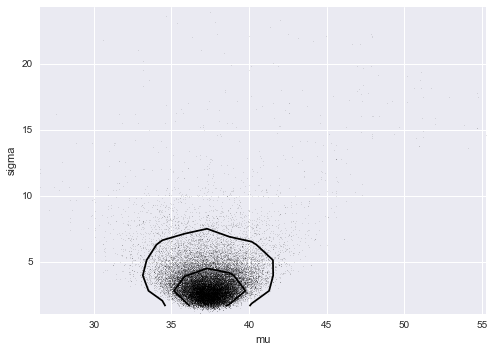

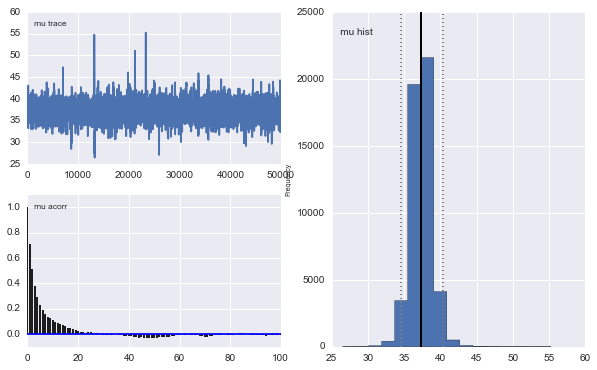

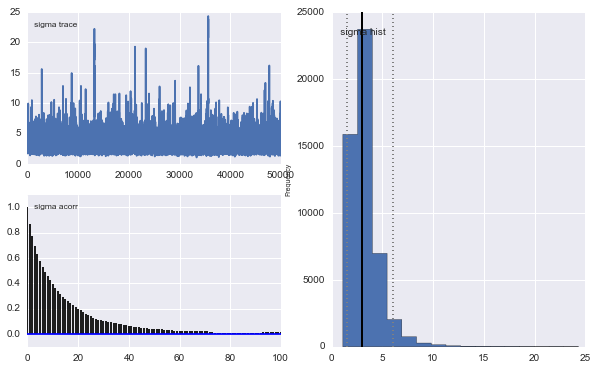

In [13]:
# something's the matter with pymc plotting, suppress the warnings
import warnings

print_CIs(normal_M, ['mu','sigma'])
plot_2d_MCMC_trace(normal_M, ['mu', 'sigma'], scatter=True, colors='k')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pymc_plot(normal_M)

## The frequentist version, using the z-score

In [119]:
def zscore_CI(sample):
    return scipy.stats.norm(loc=sample.mean(), scale=sample.std()/len(sample)**0.5).interval(0.95)

zscore_CI(sample)

(35.346835860625397, 39.401001358942942)

## The frequentist version, using the t-distribution

In [120]:
def tdist_CI(sample):
    return scipy.stats.t(len(sample)-1, loc=sample.mean(), scale=sample.std()/len(sample)**0.5).interval(0.95)

tdist_CI(sample)

(34.71530746314852, 40.032529756419819)

## Verify the CI procedures

In [46]:
def verify_CI(CI_procedure, data_generator, true_mean, iterations=1000):
    in_interval_count = 0
    for i in range(iterations):
        data = data_generator()
        CI_interval = CI_procedure(data)
        in_interval_count += (CI_interval[0] <= true_mean <= CI_interval[1])
    return 1.0 * in_interval_count / iterations

In [146]:
verify_CI(zscore_CI, data_generator, 36, iterations=10000)

0.8641

In [145]:
verify_CI(tdist_CI, data_generator, 36, iterations=10000)

0.9368

In [179]:
verify_CI(fast_bayes_CI, data_generator, 36, iterations=10000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.4 sec

0.936

In [143]:
verify_CI(zscore_CI, lambda: data_generator(samp_size=100), 36, iterations=10000)

0.9474

In [144]:
verify_CI(tdist_CI, lambda: data_generator(samp_size=100), 36, iterations=10000)

0.9499

In [ ]:
# this is just too slow to run, but it should give the same results as tdist_CI
#verify_CI(fast_bayes_CI, lambda: data_generator(samp_size=100), 36, iterations=1000)

Both the z-score-based CI and the t-dist-based CI are overconfident with samp_size=6, but do well for samp_size=100. Interestingly, Bayes is also slightly overconfident with samp_size=6. It's likely because of the prior on standard deviation, pushing towards smaller values of it.

# Bayesian CIs on lopsided binomial data

In [14]:
# sample from a very biased coin to make the CI's on p interesting
samp_size = 30
def data_generator(samp_size=samp_size):
    true_p = 0.95
    return np.random.binomial(samp_size, true_p)

np.random.seed(42)
sample = data_generator(samp_size)

In [212]:
# sample estimate of p
1.0 * sample / samp_size

0.9666666666666667

In [198]:
def get_binom_pymc_model(sample, sample_size=samp_size):
    # haldine uninformative prior: p^−1*(1−p)^−1
    # we could have also used jeffry's: p^−1/2*(1−p)^−1/2
    # https://en.wikipedia.org/wiki/Prior_probability#Uninformative_priors
    # It's not clear which is better, they're both called uninformative.
    # It really depends on the case, and your choice doesn't matter that
    # much since they're both relatively uninformative.
    # Their weight is roughly that of one observation.
    # It turns out, though, that the flat prior is best.
    @pymc.stochastic(observed=False)
    def p(value=0.5):
        #return -np.log((value+1e-5)*(1-value+1e-5))
        #if 0 <= value <= 1:
        #    return 0
        #return -np.inf
        return 0

    x = pymc.Binomial('x', n=sample_size, p=p, value=sample, observed=True)
    
    model_binom = dict(p=p, x=x)
    binom_M = pymc.MCMC(model_binom)
    binom_M.sample(iter=100000, burn=10000, thin=5)
    return binom_M

In [199]:
binom_M = get_binom_pymc_model(sample)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.2 sec

95% HPD credible interval for p: 0.856 - 0.998. post mean: 0.937 post median: 0.946 mc_error: 0.000
Plotting p


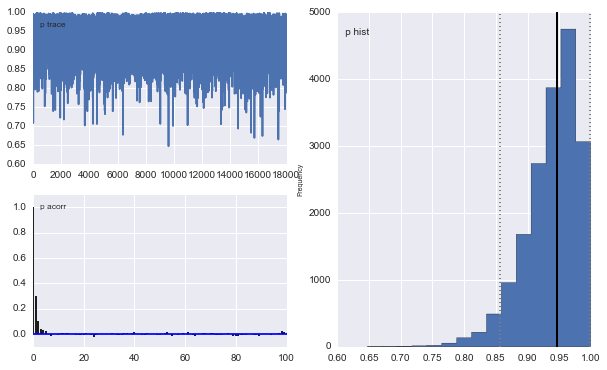

In [200]:
print_CIs(binom_M, ['p'])
#plot_2d_MCMC_trace(binom_M, ['mu', 'sigma'], scatter=True, colors='k')
pymc_plot(binom_M)

In [201]:
def memoize(f):
    """ Memoization decorator for a function taking a single argument """
    class memodict(dict):
        def __missing__(self, key):
            ret = self[key] = f(key)
            return ret 
    return memodict().__getitem__

In [202]:
@memoize
def binom_bayes_CI(sample):
    binom_M = get_binom_pymc_model(sample)
    CI = binom_M.stats()['p']['95% HPD interval']
    binom_M.halt()
    return CI

## Frequentist approaches

In [40]:
def get_norm_approx_moments(sample, samp_size):
    mu_hat = sample
    phat = 1.0 * sample / samp_size
    se = (samp_size * phat * (1-phat)) ** 0.5
    return mu_hat, se

In [50]:
def binom_tdist_CI(sample, samp_size=samp_size):
    mu_hat, se = get_norm_approx_moments(sample, samp_size)
    return np.array(scipy.stats.t(
            samp_size-1, 
            loc=mu_hat, 
            scale=se
        ).interval(0.95))/samp_size

In [51]:
def binom_norm_CI(sample, samp_size=samp_size):
    mu_hat, se = get_norm_approx_moments(sample, samp_size)
    return np.array(scipy.stats.norm(
            loc=mu_hat, 
            scale=se
        ).interval(0.95))/samp_size

In [57]:
binom_tdist_CI(sample, samp_size)

array([ 0.89963821,  1.03369512])

In [44]:
binom_norm_CI(sample, samp_size)

array([ 0.90243263,  1.0309007 ])

The result of R's binom.test:
* 0.8278305 0.9991564

## An exact method based on the likelihood

In [93]:
def binom_likelihood(p, x, n):
    # this is only proportional, it's not normalized
    return p ** x * (1-p) ** (n-x)

In [125]:
likelihood_xs = np.linspace(0,1, 1000)
likelihood_profile = binom_likelihood(likelihood_xs, sample, samp_size)
# normalize the likelihood profile
likelihood_profile /= likelihood_profile.sum()

The maximum likelihood p:

In [123]:
likelihood_xs[likelihood_profile.argmax()]

0.96696696696696693

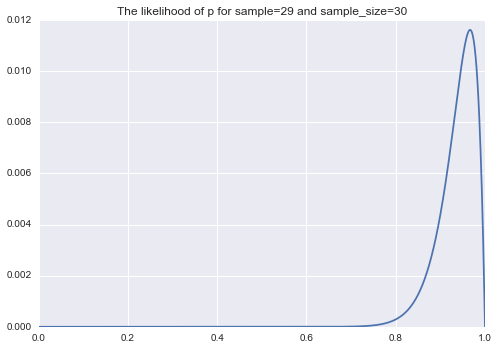

In [152]:
plt.plot(np.linspace(0,1, 1000), likelihood_profile)
plt.title('The likelihood of p for sample=29 and sample_size=30')

In [111]:
def get_area_above_thresh(thresh):
    return likelihood_profile[likelihood_profile>thresh].sum()

In [112]:
threshold = scipy.optimize.minimize_scalar(lambda x: np.abs(get_area_above_thresh(x) - 0.95)).x

In [116]:
exact_ci = likelihood_xs[likelihood_profile > threshold].min(), likelihood_xs[likelihood_profile > threshold].max()

In [117]:
exact_ci

(0.85585585585585588, 0.99799799799799804)

In [207]:
# double check that the 95% CI contains 95% of the likelihood mass
likelihood_profile[likelihood_profile > threshold].sum()

0.94990164147171596

In [209]:
# compute the expected value of p based on the likelihood distribution
np.dot(likelihood_profile, likelihood_xs)

0.93749514659414945

In [175]:
def binom_likelihood_CI(sample, sample_size=samp_size):
    likelihood_xs = np.linspace(0,1, 1000)
    likelihood_profile = binom_likelihood(likelihood_xs, sample, samp_size)
    # normalize the likelihood profile
    likelihood_profile /= likelihood_profile.sum()
    threshold = scipy.optimize.minimize_scalar(lambda x: np.abs(get_area_above_thresh(x) - 0.95)).x
    exact_ci = likelihood_xs[likelihood_profile > threshold].min(), likelihood_xs[likelihood_profile > threshold].max()
    return exact_ci

In [210]:
# confirm that it performs well when sample==sample_size
binom_likelihood_CI(30)

(0.90390390390390385, 1.0)

## Verify the CI procedures

In [54]:
verify_CI(binom_norm_CI, data_generator, 0.95, iterations=1000)

0.777

In [55]:
verify_CI(binom_tdist_CI, data_generator, 0.95, iterations=1000)

0.791

The issue with all of the above methods is that they don't include p=0.95 in the confidence interval when sample=30. Since sampling 30 is pretty common when sample_size=30 and true_p=0.95, these methods all exclude the true value too often.

In [197]:
verify_CI(binom_bayes_CI, data_generator, 0.95, iterations=1000)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.5 sec

0.988

Strangely, the bayesian CI is too conservative.

In [135]:
verify_CI(binom_likelihood_CI, data_generator, 0.95, iterations=10000)

0.9404

The likelihood CI is the closest, not sure if it's off by 0.01 because of sampling error for the verification or something else.

### Compare the likelihood CI's to the Bayesian CI's for several different values

In [203]:
binom_likelihood_CI(20), binom_bayes_CI(20)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.2 sec

((0.5285285285285285, 0.7877877877877878), array([ 0.50157036,  0.82251182]))

In [204]:
binom_likelihood_CI(28), binom_bayes_CI(28)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.2 sec

((0.81381381381381379, 0.98698698698698695), array([ 0.8076582,  0.9881025]))

In [205]:
binom_likelihood_CI(29), binom_bayes_CI(29)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.3 sec

((0.85585585585585588, 0.99799799799799804), array([ 0.85363989,  0.99786533]))

In [206]:
binom_likelihood_CI(30), binom_bayes_CI(30)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.1 sec

((0.90390390390390385, 1.0), array([ 0.90758858,  0.99999715]))

Note that the Bayesian CI is overly conservative, especially for smaller sample values.

## Discussion

The frequentist methods fail, but the Bayesian method misses the mark, too. For some reason, the prior on p pushes the CIs wider than they should be. On the flip side, if we pick a Jeffry's or Haldine prior, the prior on p pushes the CIs too far towards the edges of the distribution, resulting in an overly-narrow confidence interval in our case. I'm not sure how to get a result out of the Bayesian approach that gives the same result as the likelihood.

Only the likelihood-based method produces a good result.

# Bayesian Linear Regression

In [6]:
# create some data for linear regression: 
np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

## Plot our data

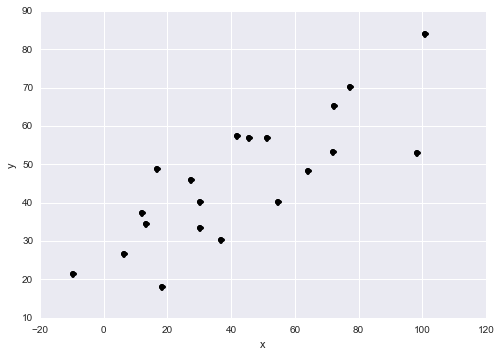

In [10]:
plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y')

In [43]:
# Define the variables needed for the routine, with their prior distributions
alpha = pymc.Uniform('alpha', -100, 100)

@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value ** 2)

# Jeffry's prior on scale parameters
@pymc.stochastic(observed=False)
def sigma(value=1):
    if value < 0:
        return -np.inf
    return -np.log(value)

# Define the form of the model and likelihood
@pymc.deterministic
def y_model(x=xdata, alpha=alpha, beta=beta):
    return alpha + beta * x

y = pymc.Normal('y', mu=y_model, tau=1. / sigma ** 2, observed=True, value=ydata)

# package the full model in a dictionary
lin_reg_model = dict(alpha=alpha, beta=beta, sigma=sigma,
                     y_model=y_model, y=y)

In [41]:
# run the basic MCMC
M = pymc.MCMC(lin_reg_model)
M.sample(iter=100000, burn=50000)

 [-----------------100%-----------------] 100000 of 100000 complete in 18.1 sec

## Display parameter estimates

95% credible interval for alpha: 19.454369 - 35.652780. MAP est: 27.267720
95% credible interval for beta: 0.256930 - 0.585687. MAP est: 0.423155
95% credible interval for sigma: 7.333712 - 14.405355. MAP est: 10.040143


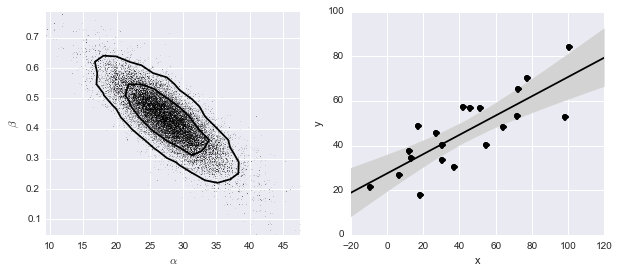

In [30]:
plot_lin_reg_results(xdata, ydata, M)

In [32]:
# the true values for comparison
theta_true

(25, 0.5)

## OLS linear regression for comparison

In [39]:
from sklearn import linear_model
ols_model = linear_model.LinearRegression()
ols_model.fit(xdata[:, None], ydata)
ols_model.intercept_, ols_model.coef_[0]

(27.109680578645815, 0.44115599839219188)

It's odd, OLS & Bayesian regression are close but not identical. Are the priors interfering? Is it just because there are too few samples from the MCMC?